In [40]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.backend import concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from imagePreprocess import getImagesVarAndMean

In [18]:
# TODO:
# find how to use multithreading in jupyter on windows
# unet
# standardize images
dataDir = 'data/resized/'

In [3]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

In [4]:
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

(1008, 1600, 3)


In [5]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [22]:
def loadImgHsv(path):
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [25]:
params = {'dim': (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}

data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.01
splitAt = int(len(data_IDs)*trainSplitPercent)
print('splitat', splitAt)
train_IDs = data_IDs[:splitAt]
print('train len', len(train_IDs))
splitValAt = int(splitAt + splitAt/10)
val_IDs = data_IDs[splitAt:splitValAt]
print('val len', len(val_IDs))

training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape )

dataset size 202599
splitat 2025
train len 2025
val len 202
(32, 128, 128, 2)


In [116]:
# tmp = []
# print(len(training_generator))
# for i in range(len(training_generator)):
#     tmp.append(training_generator[i])
# print(len(tmp))
# tmp[0]


In [41]:
def createModel(input_shape):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    mul = 2
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv5 = Conv2D(128*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    up6 = Conv2D(64*mul, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv3, up6], axis=3)
    conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    
    up7 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2, up7], axis=3)
    conv7 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    
    up8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1, up8], axis=3)
    conv8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    # todo change to sigmoid
    conv8 = Conv2D(2, 1, activation = 'relu')(conv8)
    
    model = Model(inputs=inputs, outputs=conv8)
    
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae','accuracy'])
    return model

model = createModel(params['dim'])
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 128, 128, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_85[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 64, 64, 64)   18496       max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
max_poolin

In [42]:
x = model.layers[0]
x.input

<tf.Tensor 'input_7:0' shape=(?, 128, 128, 1) dtype=float32>

In [44]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet1']
NAME = f"test-tensorboard-{ currTime }-layers-" + "_".join(str(l) for l in layers)
print(NAME)

model = createModel(params['dim'])
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
#mode.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, callbacks=[tensorboard])

test-tensorboard-08-05-2019-19-32-00-layers-unet1
Epoch 1/1
63/63 [==============================] - 17s 275ms/step - loss: 6547.1173 - mean_absolute_error: 54.5386 - acc: 0.6536 - val_loss: 4539.9082 - val_mean_absolute_error: 46.9028 - val_acc: 0.7216


In [48]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])

Epoch 1/10
63/63 [==============================] - 12s 187ms/step - loss: 4199.6479 - mean_absolute_error: 45.4900 - acc: 0.7214 - val_loss: 4220.9433 - val_mean_absolute_error: 45.1453 - val_acc: 0.7210
Epoch 2/10
63/63 [==============================] - 12s 186ms/step - loss: 4067.4782 - mean_absolute_error: 44.6630 - acc: 0.7215 - val_loss: 4128.0441 - val_mean_absolute_error: 44.6149 - val_acc: 0.7211
Epoch 3/10
63/63 [==============================] - 11s 182ms/step - loss: 3965.2358 - mean_absolute_error: 43.9558 - acc: 0.7217 - val_loss: 4010.8229 - val_mean_absolute_error: 43.7618 - val_acc: 0.7213
Epoch 4/10
63/63 [==============================] - 11s 182ms/step - loss: 3887.1297 - mean_absolute_error: 43.4153 - acc: 0.7230 - val_loss: 3979.8635 - val_mean_absolute_error: 43.2495 - val_acc: 0.7224
Epoch 5/10
63/63 [==============================] - 11s 182ms/step - loss: 3820.2726 - mean_absolute_error: 42.8797 - acc: 0.7236 - val_loss: 4019.7085 - val_mean_absolute_error: 4

In [94]:
def showImgFromPredict(hs, v, showDetails=False):
    '''hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    print('h',h.shape,'s',s.shape,'v',v.shape)
    print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    # showHsv(hsv)    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
    
    f, axarr = plt.subplots(1,4, figsize=(15,15))
    
    axarr[0].imshow(img)
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        #axarr.title(['hue', 'saturation', 'value'][i])
        axarr[1+i].title.set_text(['hue', 'saturation', 'value'][i])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()

In [95]:
def predictFromImage(img, showDetails=False):
    X, Y = validation_generator[1]
    print('xshape',X.shape, 'yshape',Y.shape)

    inX, inY = loadImgHsv(img )
    #print(inX.shape,inY.shape)
    inX, inY = inX[None,...,None], inY[None,:]
    #print(inX.shape,inY.shape)
    X, Y = X[10][None,:], Y[0][None,:]
    #print(X.shape, Y.shape)

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)

    #print(X.dtype, X.min(), X.max(), X.mean())
    #predY = int(predY)
    print('predyshape',predY.shape)
    print(predY.min(), predY.max(), predY.mean() )
    print(predY.min(), predY.max(), predY.mean() )
    predY = predY
    predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    #print(predY.min(), predY.max(), predY.mean() )
    #predY[:,0] += 100
    hue = predY[:,0]
    print('hue',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 172.66316 37.293453
0.0 172.66316 37.293453
hue 0 69 27.08984375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


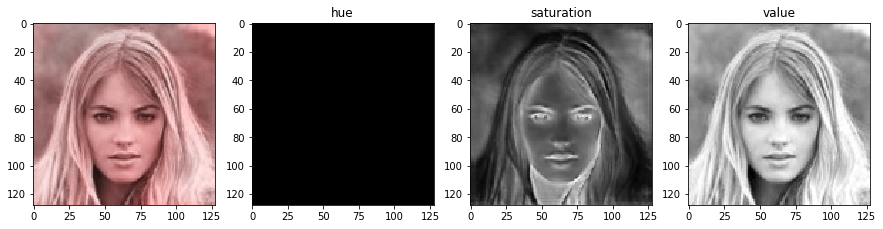

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 196.14072 44.65901
0.0 196.14072 44.65901
hue 0 129 37.1484375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


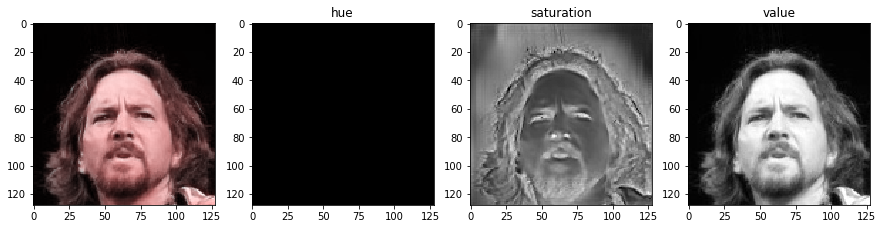

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 171.66788 37.16699
0.0 171.66788 37.16699
hue 0 53 16.8359375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


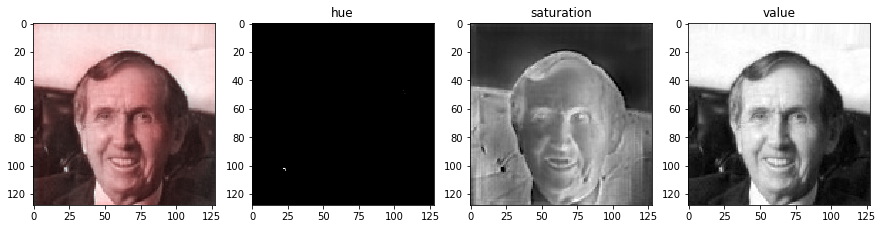

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 169.0579 35.38669
0.0 169.0579 35.38669
hue 0 48 15.26171875
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


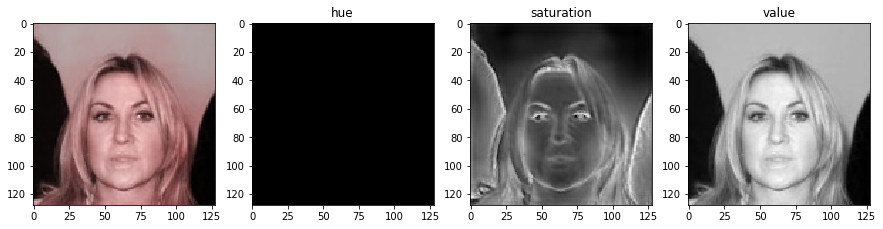

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 152.0033 27.529663
0.0 152.0033 27.529663
hue 0 72 16.234375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


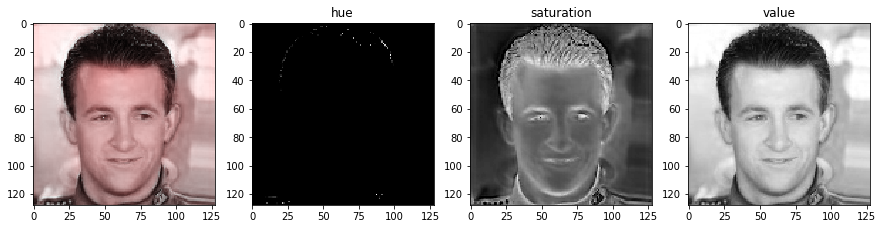

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 183.11612 30.551449
0.0 183.11612 30.551449
hue 0 72 21.6640625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


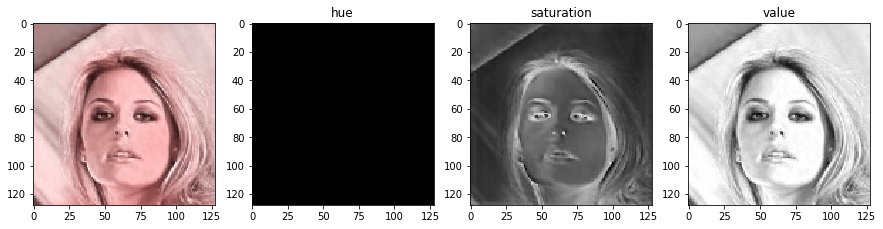

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 186.40381 39.49389
0.0 186.40381 39.49389
hue 0 104 36.7890625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


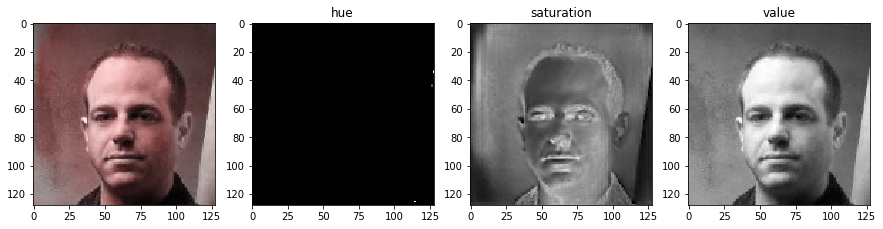

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 177.6062 37.269226
0.0 177.6062 37.269226
hue 0 59 18.12890625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


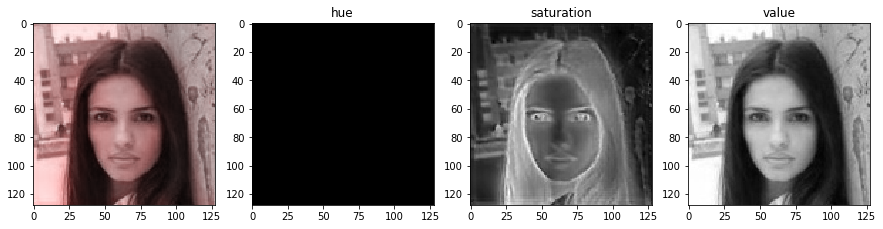

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 194.09898 39.240364
0.0 194.09898 39.240364
hue 0 100 23.07421875
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


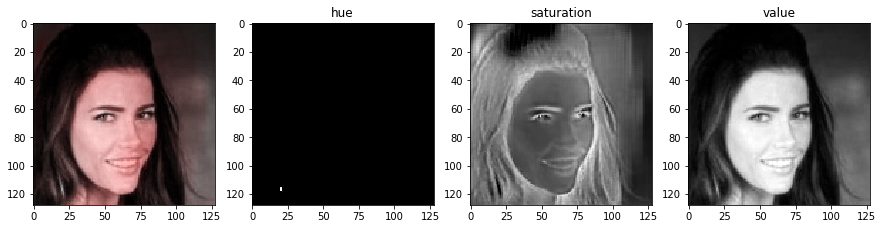

In [97]:
for i in range(1,10):
    predictFromImage(f'data/resized/0000{i+18:2}.jpg', True)
